<a href="https://colab.research.google.com/github/sumitmukherjee7/express/blob/master/notebooks/Context_Mixing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Context Mixing in Transformers**

---

Authors: Hosein Mohebbi & Willem Zuidema

---

In this notebook, we explore measures of the degree of *context-mixing* in Transformer language models, and the ways to compute and visualize these measures. The notebook is part of the EACL tutorial on *Transformer-specific Interpretability Methods* at EACL2024.

# **Section 1: Preliminaries**

In [1]:
# @title Install Requirements
from IPython.display import clear_output
!git clone https://github.com/hmohebbi/context_mixing_toolkit.git
!pip install -r /content/context_mixing_toolkit/requirements.txt
clear_output()

In [2]:
# @title Import Libraries
import pandas as pd
from plotnine import *
from IPython.display import display
import numpy as np
import torch
from huggingface_hub import notebook_login
from transformers import AutoTokenizer
from context_mixing_toolkit.src.modeling_bert import BertModel
from context_mixing_toolkit.src.modeling_roberta import RobertaModel
from context_mixing_toolkit.src.modeling_gemma import GemmaModel
from context_mixing_toolkit.src.utils import CMConfig, normalize, rollout

In [3]:
# @title Login to HuggingFace Hub (needed only if you run Gemma model)
notebook_login()

# **Section 2: Raw Attention & Attention Rollout**

In 2018/2019, after the publication of the Transformer architecture and BERT in the two years before that, a lively debate existed about whether *attention weights* could be considered explanations. We start this tutorial with retrieving and visualizing raw self-attention weights in layers 2 and 11 for a simple example sentence in the Roberta-base model. We assume visualizing attention weights is known territory, and you can simply run the 3 code blocks below to obtain the type of visualizations that we will use in this notebook.

In [4]:
# @title set input
INPUT_EXAMPLE_S2 = "Either you win the game or you <mask> the game." # "The author talked to Sara about <mask> book"

In [5]:
# @title Compute scores
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")
model.eval()

inputs_s2 = tokenizer(INPUT_EXAMPLE_S2, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs_s2, output_attentions=True)

scores_s2 = {}
scores_s2['Attention'] = torch.stack(outputs['attentions']).permute(1, 0, 2, 3, 4).squeeze(0).mean(1).detach().cpu().numpy()
scores_s2['Attention-Rollout'] = rollout(scores_s2['Attention'], res=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# @title Plot attention matrices
tokens = [tokenizer.convert_ids_to_tokens(t) for t in inputs_s2['input_ids'][0].detach().cpu().numpy().tolist()]
token_orders = list(range(len(tokens)))
order_to_token_mapper = {i: tokens[i] for i in token_orders}

NAMES = list(scores_s2.keys())
num_layers, seq_len, _= scores_s2[NAMES[0]].shape
for l in {1,10}:
    df_list = []
    for name in NAMES:
        df = pd.DataFrame(scores_s2[name][l], index=token_orders, columns=token_orders).reset_index()
        df = df.melt(id_vars='index')
        df.columns = ['x', 'y', 'value']
        df['method'] = name
        df_list.append(df)
    merged_df = pd.concat(df_list)
    merged_df['x'] = pd.Categorical(merged_df['x'], categories=token_orders)
    merged_df['y'] = pd.Categorical(merged_df['y'], categories=token_orders)

    p = (ggplot(merged_df, aes('y', 'x', fill='value'))
        + geom_tile()
        + scale_fill_gradient(low='white', high='green', guide=False)
        + facet_wrap('~method')
        + theme(axis_text_x=element_text(rotation=90, hjust=1), axis_title_x=element_blank(), axis_title_y=element_blank(), figure_size=(6, 4))
        + scale_x_discrete(labels=[order_to_token_mapper[i] for i in token_orders])
        + scale_y_discrete(labels=[order_to_token_mapper[i] for i in token_orders][::-1], limits=reversed)
        + labs(title=f"L{l+1}")
        )
    display(p)

PlotnineError: 'Unknown guide: False'

PlotnineError: 'Unknown guide: False'

# **Section 3: Attention-Norm**

Observing the pattern of the methods mentioned above, we notice that self-attention weights often focus on less informative tokens such as periods, commas, and special tokens within the context. Kobayashi et al. (EMNLP 2020) addressed this by emphasizing the significance of considering the effect of transformed value vectors in context-mixing analysis. They pointed out that the model might give a high attention weight to tokens with a small norm, which often occurs with frequently used but less informative words. So, a higher attention weight does not always mean a greater contribution. They proposed a norm-based context-mixing method: Attention-Norm, which in addition to the attention weights, incorporates the effect of transformed value vectors as well.

In [7]:
# @title set input
INPUT_EXAMPLE_S3 = "Either you win the game or you <mask> the game." # "The author talked to Sara about <mask> book"

In [8]:
# @title Compute scores
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")
model.eval()

cm_config = CMConfig(output_attention=True, output_attention_norm=True)

inputs_s3 = tokenizer(INPUT_EXAMPLE_S3, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs_s3, output_context_mixings=cm_config)

scores_s3 = {}
scores_s3['Attention'] = torch.stack(outputs['context_mixings']['attention']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy()
scores_s3['Attention-Norm'] = normalize(torch.stack(outputs['context_mixings']['attention_norm']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# @title Plot attention matrices
tokens = [tokenizer.convert_ids_to_tokens(t) for t in inputs_s3['input_ids'][0].detach().cpu().numpy().tolist()]
token_orders = list(range(len(tokens)))
order_to_token_mapper = {i: tokens[i] for i in token_orders}

NAMES = list(scores_s3.keys())
num_layers, seq_len, _= scores_s3[NAMES[0]].shape
for l in {1,10}:
    df_list = []
    for name in NAMES:
        df = pd.DataFrame(scores_s3[name][l], index=token_orders, columns=token_orders).reset_index()
        df = df.melt(id_vars='index')
        df.columns = ['x', 'y', 'value']
        df['method'] = name
        df_list.append(df)
    merged_df = pd.concat(df_list)
    merged_df['x'] = pd.Categorical(merged_df['x'], categories=token_orders)
    merged_df['y'] = pd.Categorical(merged_df['y'], categories=token_orders)

    p = (ggplot(merged_df, aes('y', 'x', fill='value'))
        + geom_tile()
        + scale_fill_gradient(low='white', high='green', guide=False)
        + facet_wrap('~method')
        + theme(axis_text_x=element_text(rotation=90, hjust=1), axis_title_x=element_blank(), axis_title_y=element_blank(), figure_size=(6, 4))
        + scale_x_discrete(labels=[order_to_token_mapper[i] for i in token_orders])
        + scale_y_discrete(labels=[order_to_token_mapper[i] for i in token_orders][::-1], limits=reversed)
        + labs(title=f"L{l+1}")
        )
    display(p)

PlotnineError: 'Unknown guide: False'

PlotnineError: 'Unknown guide: False'

# **Section 4: Value Zeroing**

To measure how much the token i depends on the token j when forming its representation, Value Zeroing replaces the value vector associated with the token j with a zero vector. This provides an alternative output representation for the token i that has excluded token j in the mixing process. So, by comparing the alternative output representation with the original one (using a pairwise distance function), we can measure how much the output representation i is being affected in the representation space in the absence of token j.

In contrast to general perturbation-based methods, Value Zeroing does not oblate the input token representations from a layer input. Since any changes in the input vectors will lead to changes in the query and key vectors, resulting in a change in the attention distribution, causing a discrepancy between the alternative attention weights and those we initially wanted to analyze in the original context. Value Zeroing keeps the pattern of attention flow intact in the model, and only nullifies the value vector of a specific token to not contribute to forming other token representations.

In [10]:
# @title set input
INPUT_EXAMPLE_S4 = "Either you win the game or you <mask> the game." # "The author talked to Sara about <mask> book"

In [11]:
# @title Compute scores
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")
model.eval()

inputs_s4 = tokenizer(INPUT_EXAMPLE_S3, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs_s4, output_hidden_states=True, output_attentions=True)
org_hidden_states = torch.stack(outputs['hidden_states'])
input_shape = inputs_s4['input_ids'].size()
_, seq_length = input_shape

# loop over tokens in the context, zeroing value vectors for each token by turn, and extracting alternative hidden_states for all tokens
scores_s4 = {}
_, seq_len = inputs_s4['input_ids'].size()
vz_matrix = torch.zeros(model.config.num_hidden_layers, seq_len, seq_len)
for l, layer_module in enumerate(model.encoder.layer):
  for t in range(seq_len): # can be implemented without for but at the cost of memory when having long sequences, so I keep the loop for now
      extended_attention_mask: torch.Tensor = model.get_extended_attention_mask(inputs_s4['attention_mask'], input_shape)
      alternative_layer_outputs = layer_module(
                          hidden_states=org_hidden_states[l], # previous layer's original output
                          attention_mask=extended_attention_mask,
                          value_zeroing_index=t)
      # computing cosine distance  between each alternative token representation and its original to see how much others are affected in the absence of token t's value vector
      vz_matrix[l, :, t] = 1.0 - torch.nn.functional.cosine_similarity(org_hidden_states[l+1], alternative_layer_outputs[0], dim=-1)[0]
# normalizing to sum 1 for each row
scores_s4['Value Zeroing'] = (vz_matrix / vz_matrix.sum(axis=-1, keepdims=True)).detach().cpu().numpy()
scores_s4['Attention'] = torch.stack(outputs['attentions']).permute(1, 0, 2, 3, 4).squeeze(0).mean(1).detach().cpu().numpy()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


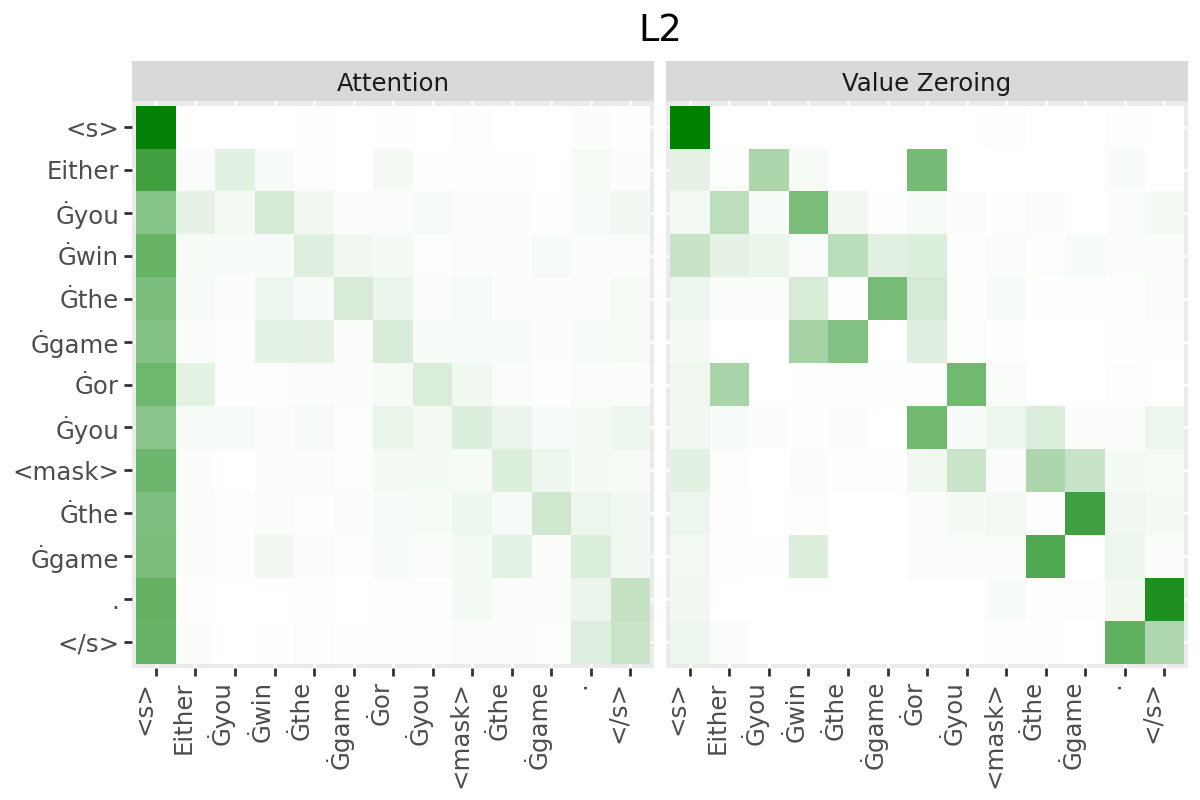

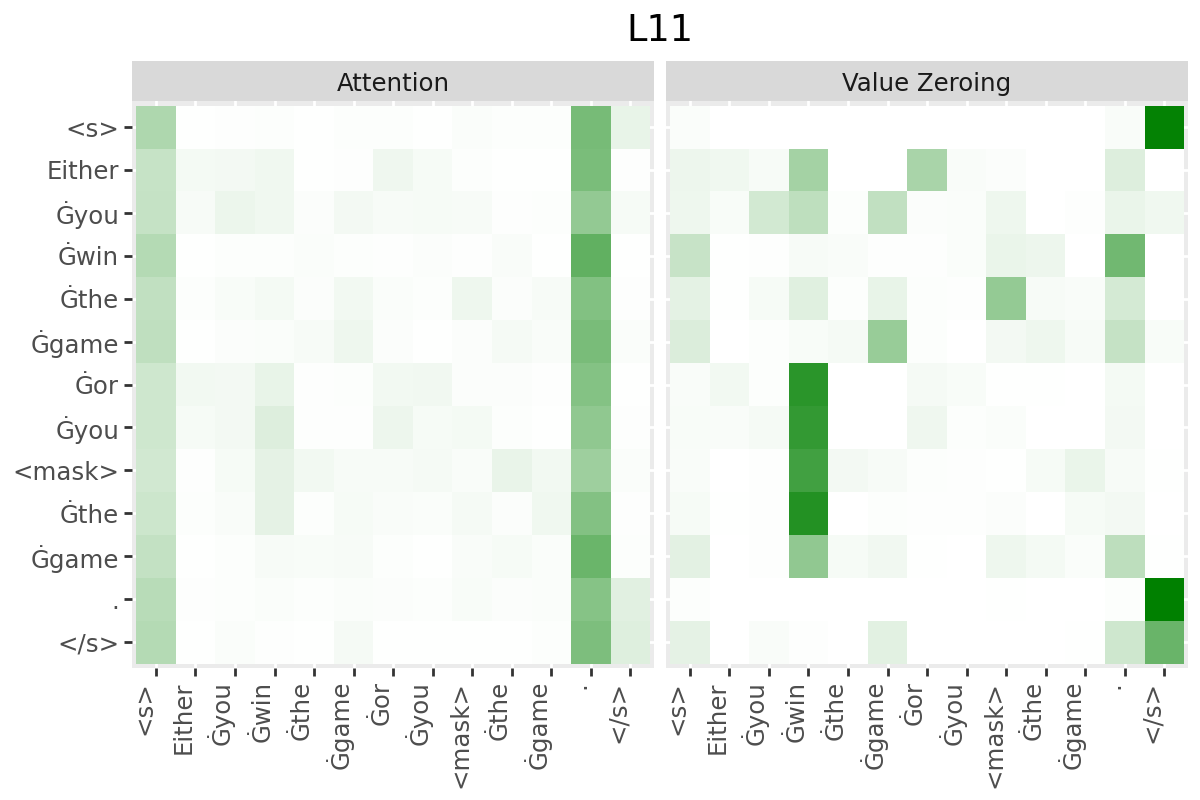

In [16]:
# @title Plot attention matrices
tokens = [tokenizer.convert_ids_to_tokens(t) for t in inputs_s4['input_ids'][0].detach().cpu().numpy().tolist()]
token_orders = list(range(len(tokens)))
order_to_token_mapper = {i: tokens[i] for i in token_orders}

NAMES = list(scores_s4.keys())
num_layers, seq_len, _= scores_s4[NAMES[0]].shape
for l in {1,10}:
    df_list = []
    for name in NAMES:
        df = pd.DataFrame(scores_s4[name][l], index=token_orders, columns=token_orders).reset_index()
        df = df.melt(id_vars='index')
        df.columns = ['x', 'y', 'value']
        df['method'] = name
        df_list.append(df)
    merged_df = pd.concat(df_list)
    merged_df['x'] = pd.Categorical(merged_df['x'], categories=token_orders)
    merged_df['y'] = pd.Categorical(merged_df['y'], categories=token_orders)

    p = (ggplot(merged_df, aes('y', 'x', fill='value'))
        + geom_tile()
        + scale_fill_gradient(low='white', high='green', guide=None)
        + facet_wrap('~method')
        + theme(axis_text_x=element_text(rotation=90, hjust=1), axis_title_x=element_blank(), axis_title_y=element_blank(), figure_size=(6, 4))
        + scale_x_discrete(labels=[order_to_token_mapper[i] for i in token_orders])
        + scale_y_discrete(labels=[order_to_token_mapper[i] for i in token_orders][::-1], limits=reversed)
        + labs(title=f"L{l+1}")
        )
    display(p)

# **Section 5: Putting it all together**

The shortcomings of attention weights as explanations, and attention rollout as an attribution method, inspired a range of attempts to define measures of context-mixing that, like attention weights show locally how information is exchanged between token repressentation within one layer, while, like attention rollout, taking into account the graph structure of the attention network and other components of the Transformer architecture than just attention weights. In this notebook, we consider:

- **Attention:** Raw self-attention weights averaged over all heads

- **Attention-Rollout:** Aggregated attention weights over previous layers using Rollout method (Abnar & Zuidema, ACL 2020)

- **Attention-Norm:** Norm of multiplication of attention weights and transformed value vectors (Kobayashi et al., EMNLP 2020)
  
- **Attention-Norm + RES1:** Incorporates the effect of the first residual stream into the Attention-Norm (Kobayashi et al., EMNLP 2021)

- **Attention-Norm + RES1 + LN1:** Incorporates the effect of the first residual stream and layer normalization into the Attention-Norm (Kobayashi et al., EMNLP 2021)

- **GlobEnc:** Rollout version of Attention-Norm + RES1 + LN1 where the effect of the second layer normalization is also taken into account (Modarressi et al., NAACL 2022)

- **Value Zeroing:** Considers all components inside Transformer by measuring how much token representations are affected when nullifying the value vector of each token (Mohebbi et al., EACL 2023)


In [13]:
# @title Your Inputs
#@markdown Choose a pre-trained model
MODEL_PATH = "roberta-base" #@param ["roberta-base", "bert-base-uncased", "google/gemma-2b"]
#@markdown Choose your own input example! (For masking in encoder-only models, use \<mask> for RoBERTa and [MASK] for BERT)
INPUT_EXAMPLE = "Either you win the game or you <mask> the game." #@param {type:"string"}
# Either you win the game or you
# Either you win the game or you <mask> the game.
# Either you win the game or you [MASK] the game.

#@markdown Choose measures of context-mixing: For Gemma model, only attention & Value Zeroing are available.
Attention = True #@param {type:"boolean"}
Attention_Rollout = True #@param {type:"boolean"}
AttentionNorm = True #@param {type:"boolean"}
AttentionNorm_RES1 = True #@param {type:"boolean"}
AttentionNorm_RES1_LN1 = True #@param {type:"boolean"}
GlobEnc = True #@param {type:"boolean"}
ValueZeroing = True #@param {type:"boolean"}



In [14]:
# @title Compute scores
cm_config = CMConfig(output_attention=Attention, output_attention_norm=AttentionNorm, output_globenc=GlobEnc, output_value_zeroing=ValueZeroing)

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
if "roberta" in MODEL_PATH:
    model = RobertaModel.from_pretrained(MODEL_PATH)
elif "bert" in MODEL_PATH:
    model = BertModel.from_pretrained(MODEL_PATH)
elif "gemma" in MODEL_PATH:
    model = GemmaModel.from_pretrained(MODEL_PATH, attn_implementation='eager') #, torch_dtype=torch.bfloat16
else:
    raise ValueError("Context mixing methods have not been implemented for this model yet!")
model.eval()

inputs = tokenizer(INPUT_EXAMPLE, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs, output_context_mixings=cm_config)

scores = {}
if Attention:
  scores['Attention'] = normalize(torch.stack(outputs['context_mixings']['attention']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())
if Attention_Rollout:
  scores['Attention-Rollout'] = rollout(scores['Attention'], res=True)
if AttentionNorm:
  scores['Attention-Norm'] = normalize(torch.stack(outputs['context_mixings']['attention_norm']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())
if AttentionNorm_RES1:
  scores['Attention-Norm + RES1'] = normalize(torch.stack(outputs['context_mixings']['attention_norm_res']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())
if AttentionNorm_RES1_LN1:
  scores['Attention-Norm + RES1 + LN1'] = normalize(torch.stack(outputs['context_mixings']['attention_norm_res_ln']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())
if GlobEnc:
  scores['GlobEnc'] = rollout(normalize(torch.stack(outputs['context_mixings']['globenc']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy()), res=False)
if ValueZeroing:
  scores['Value Zeroing'] = normalize(torch.stack(outputs['context_mixings']['value_zeroing']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


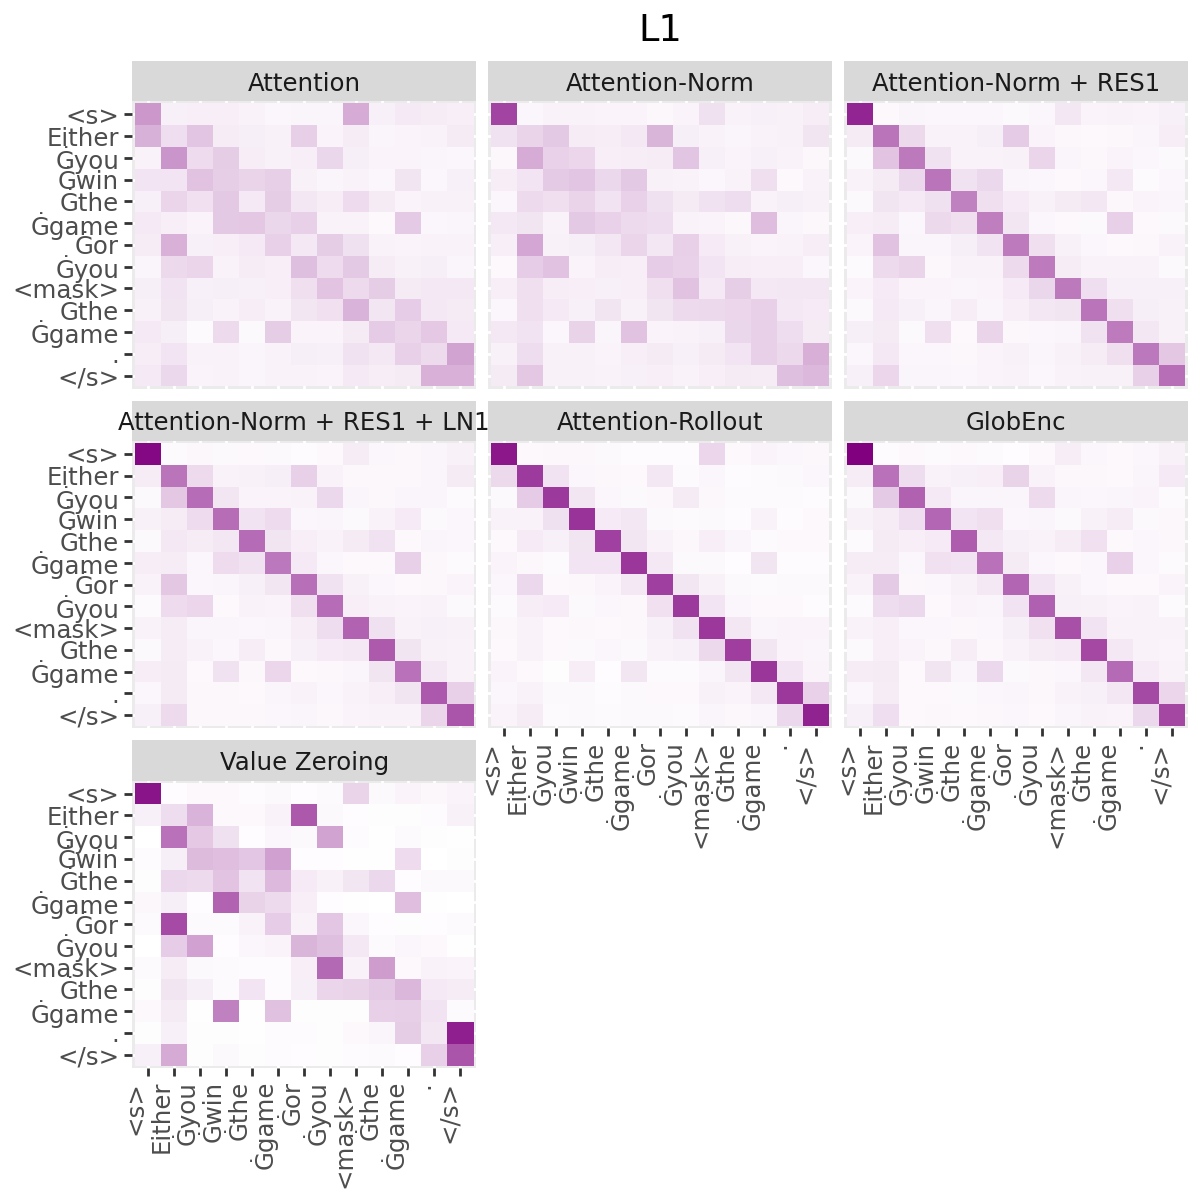

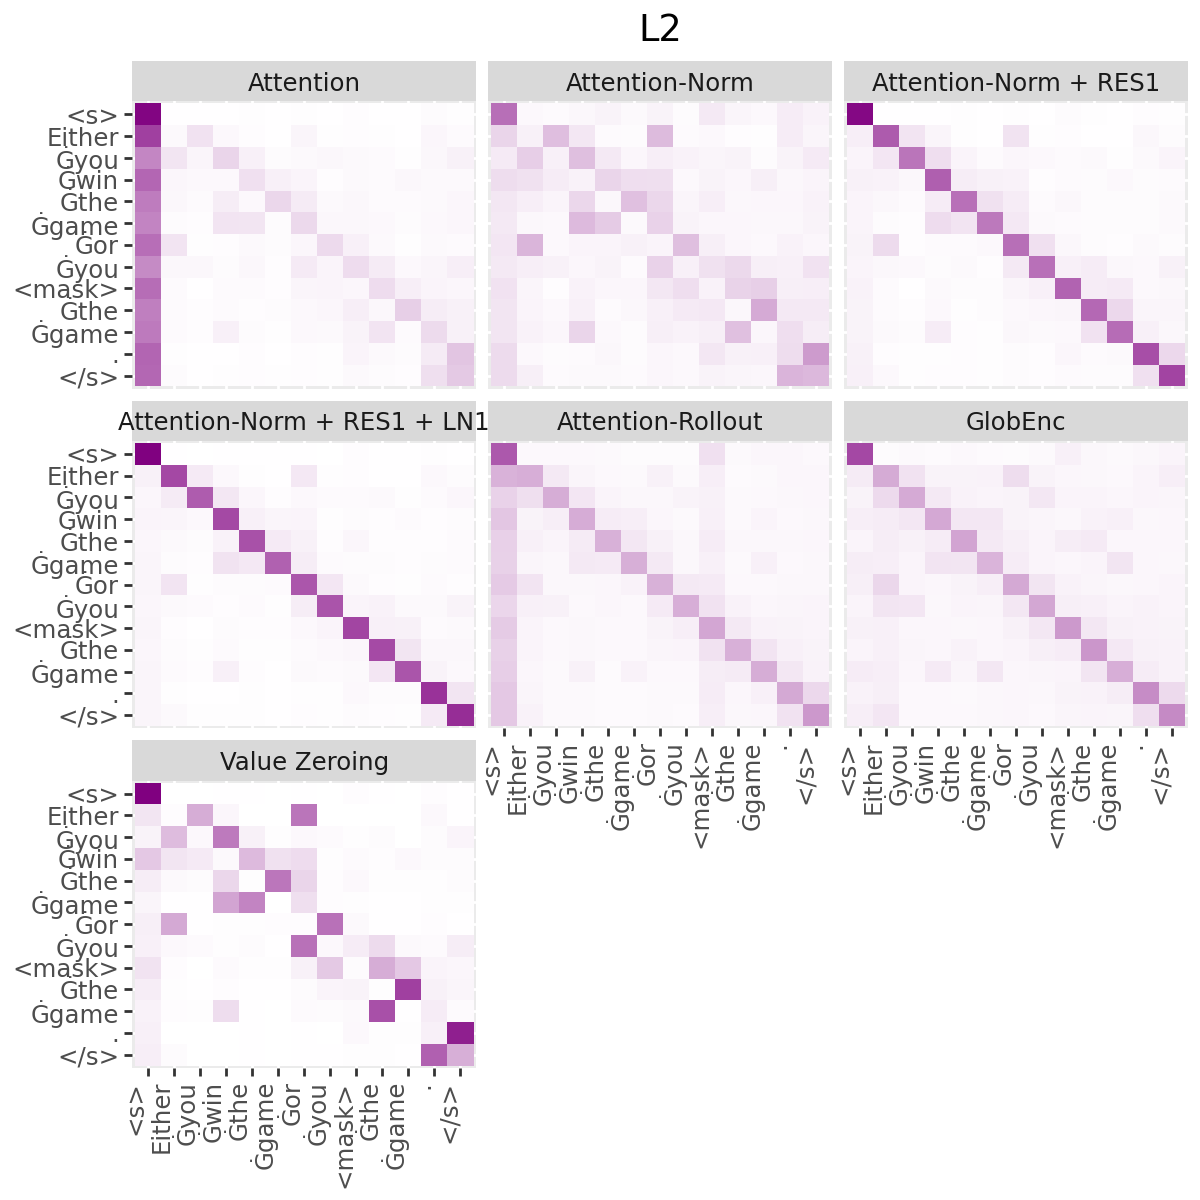

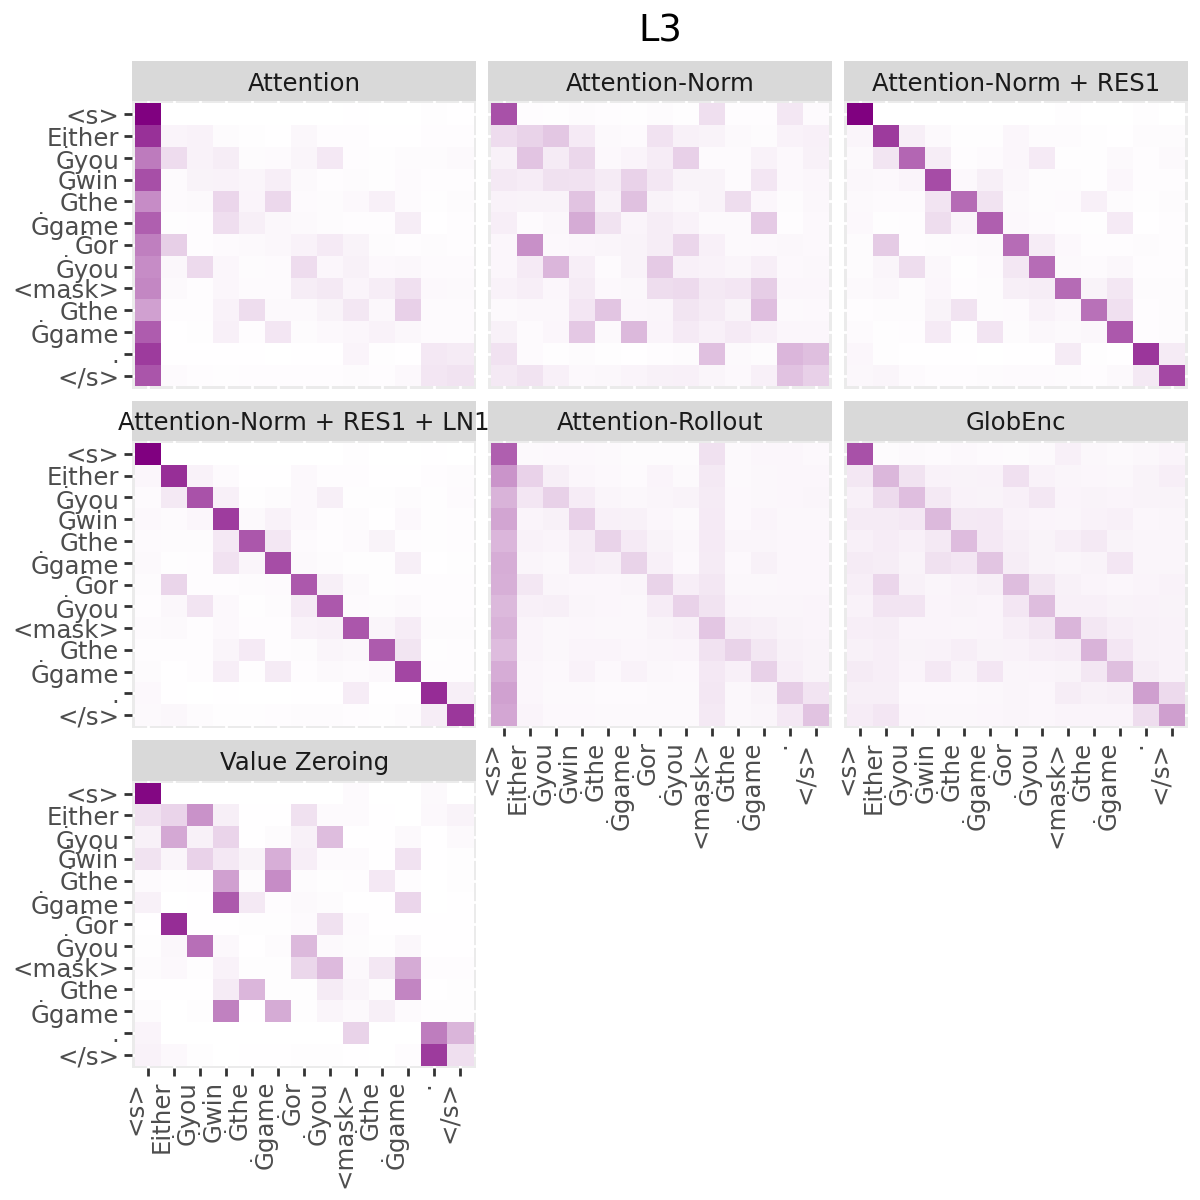

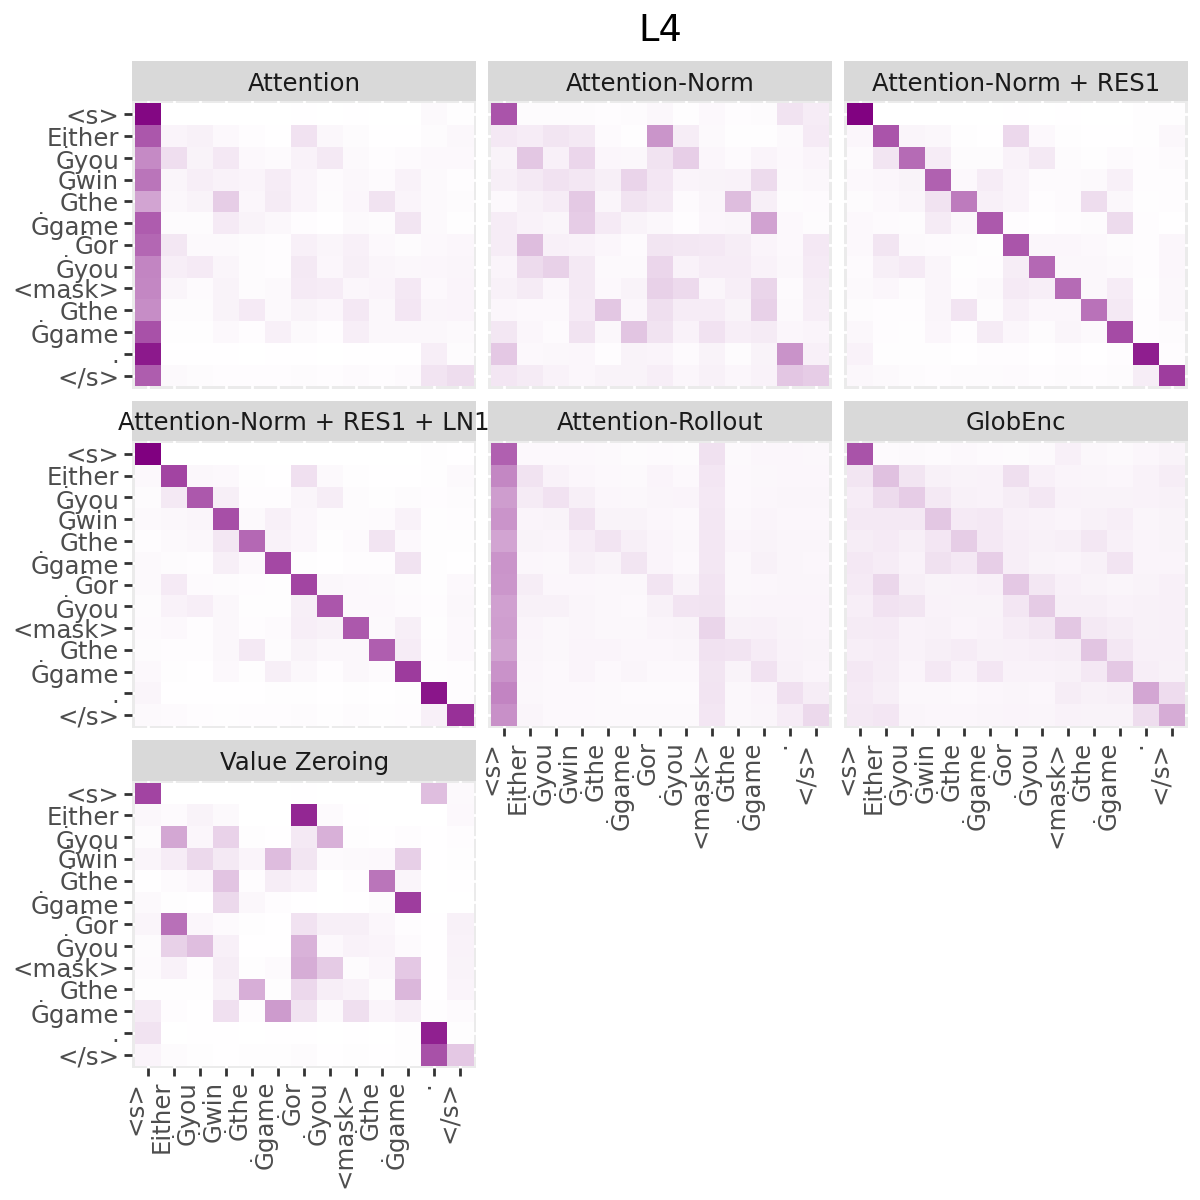

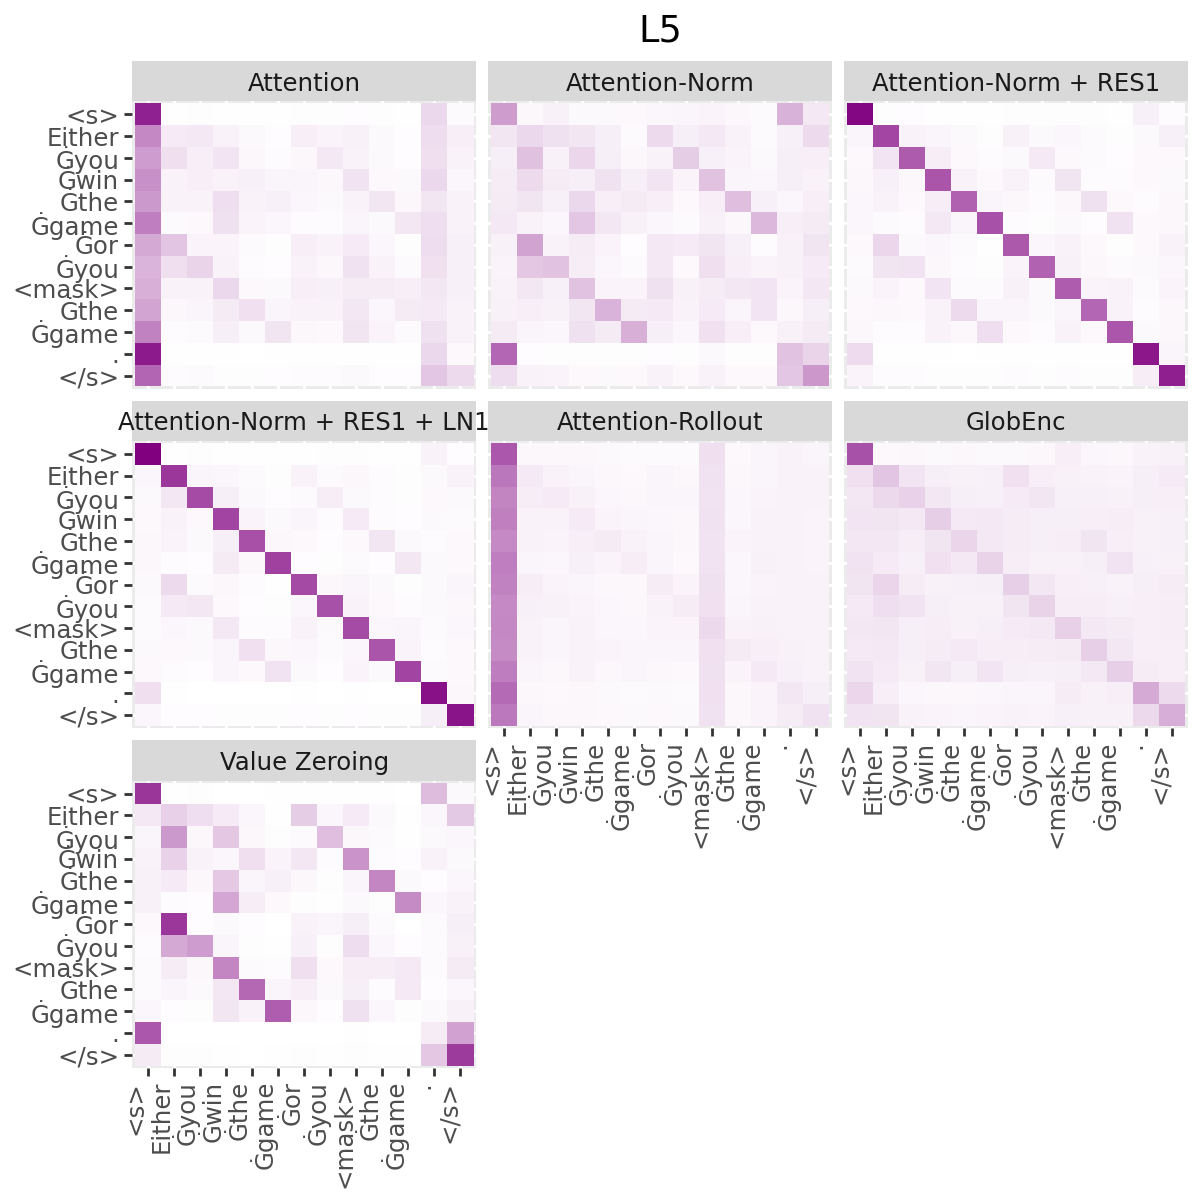

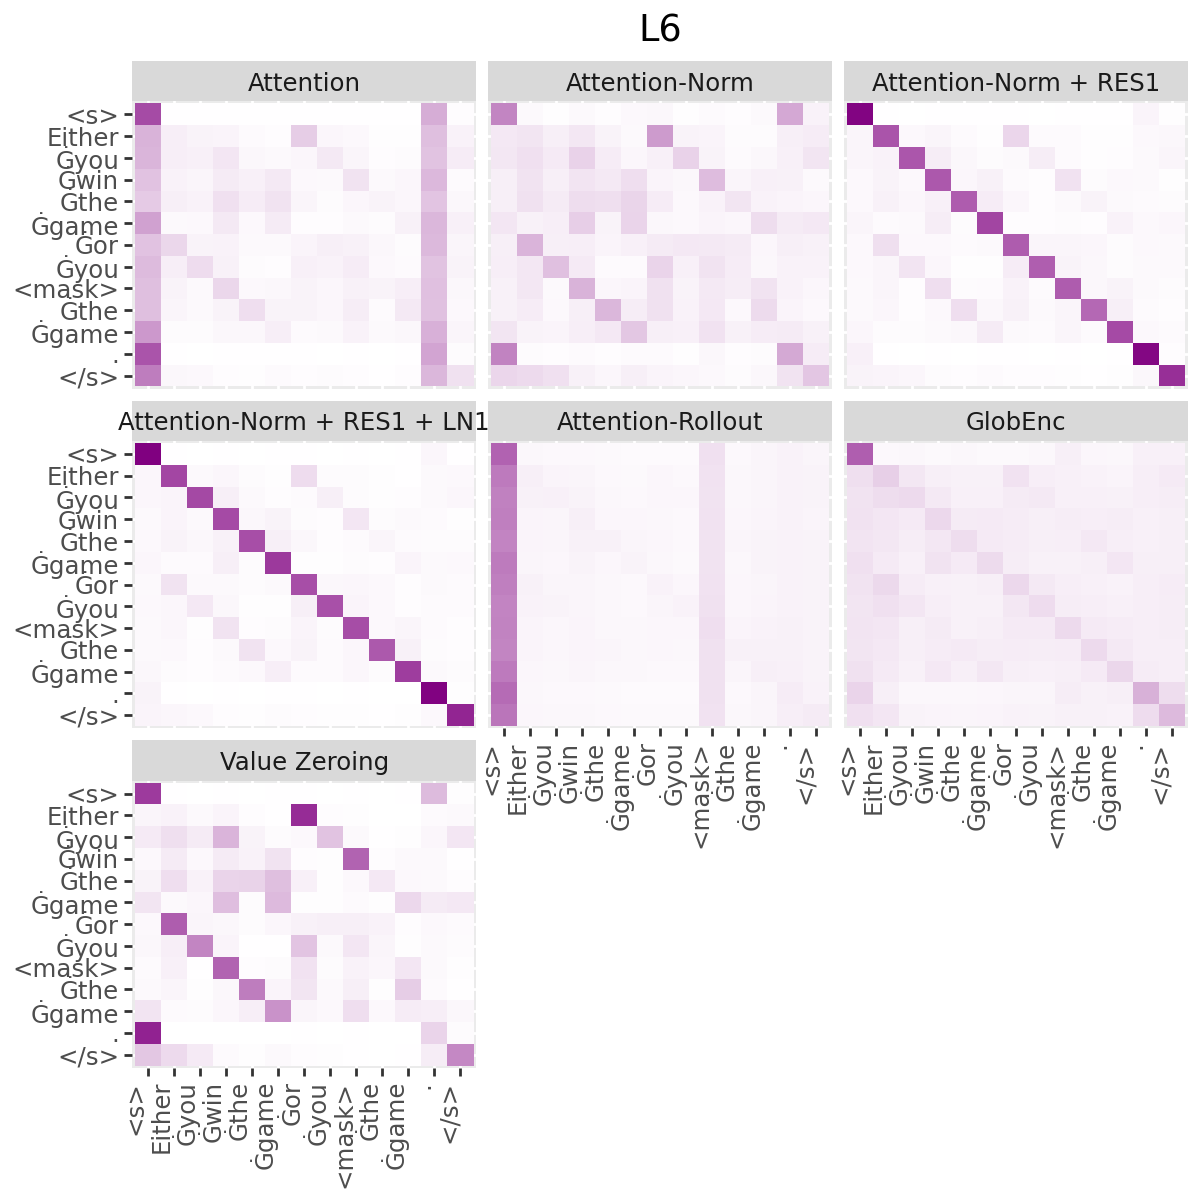

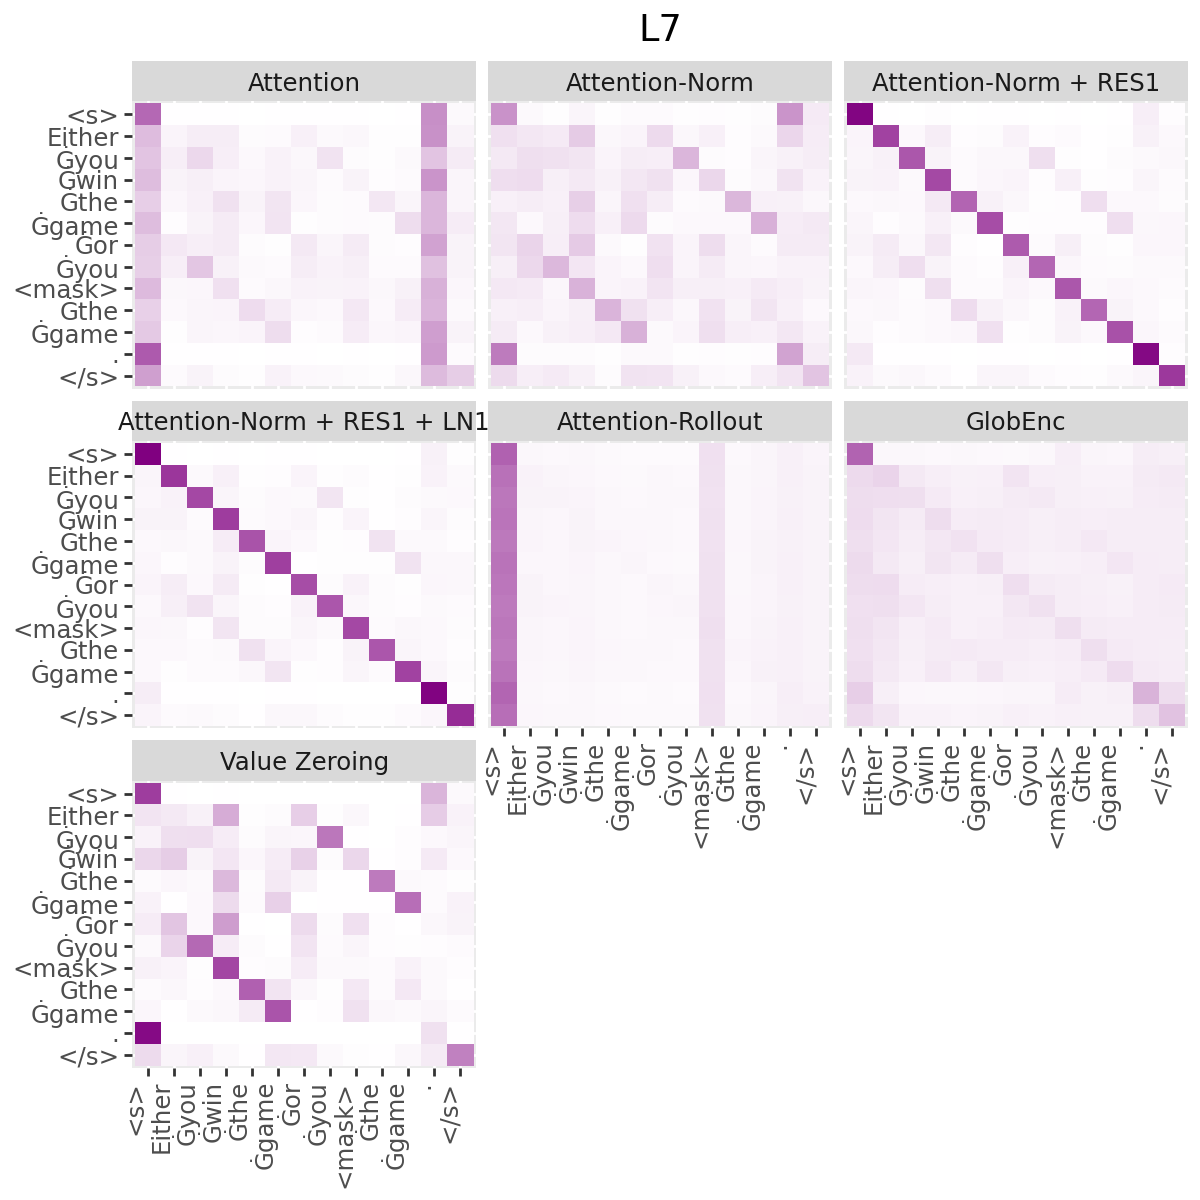

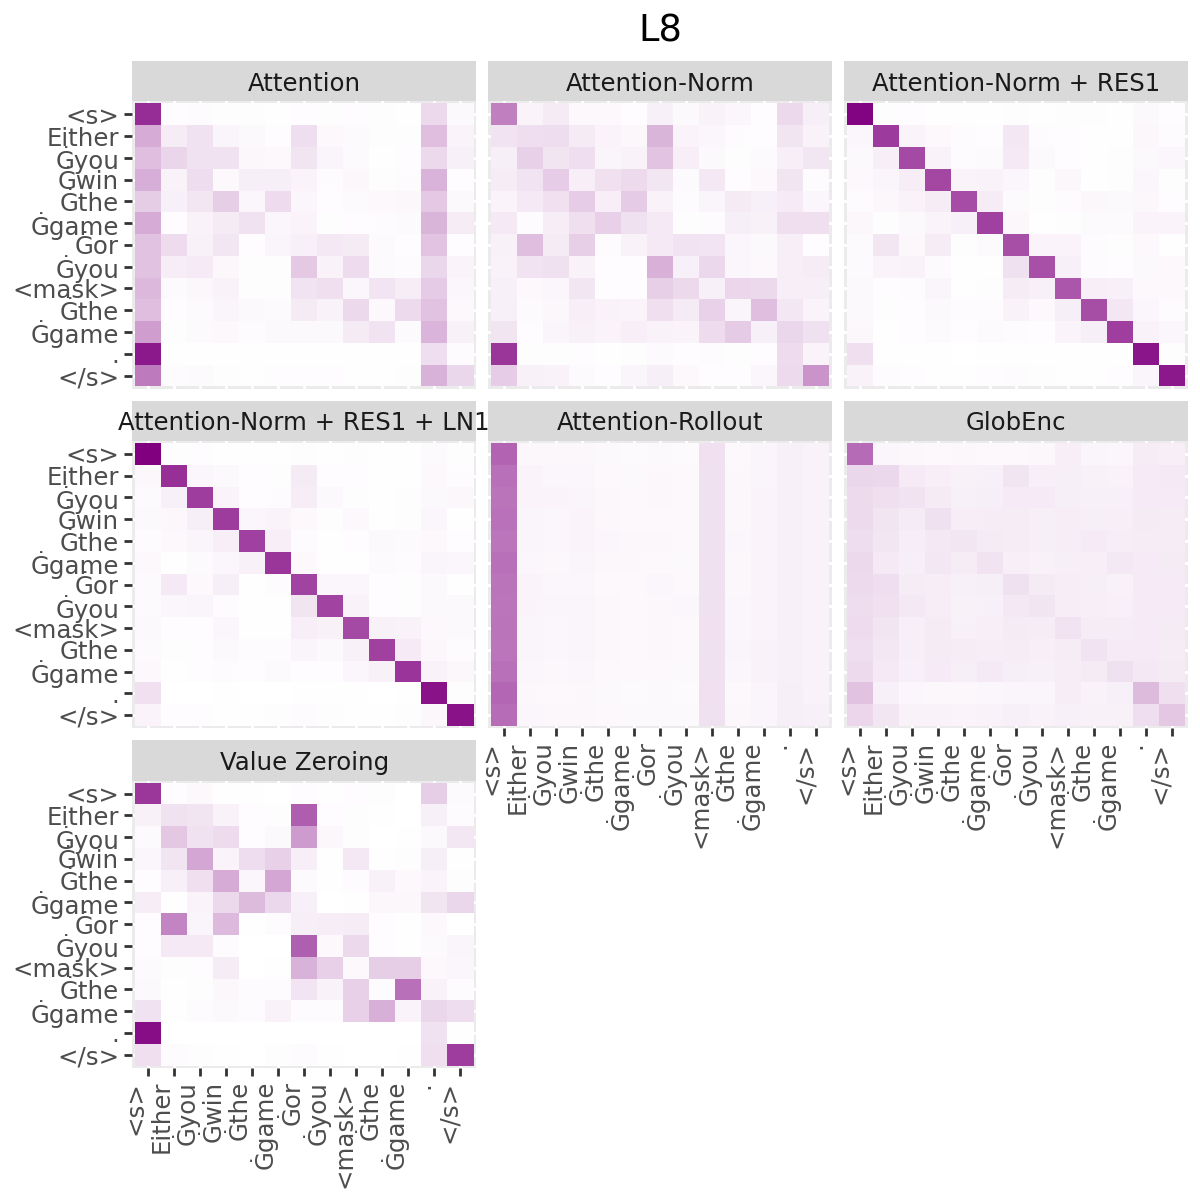

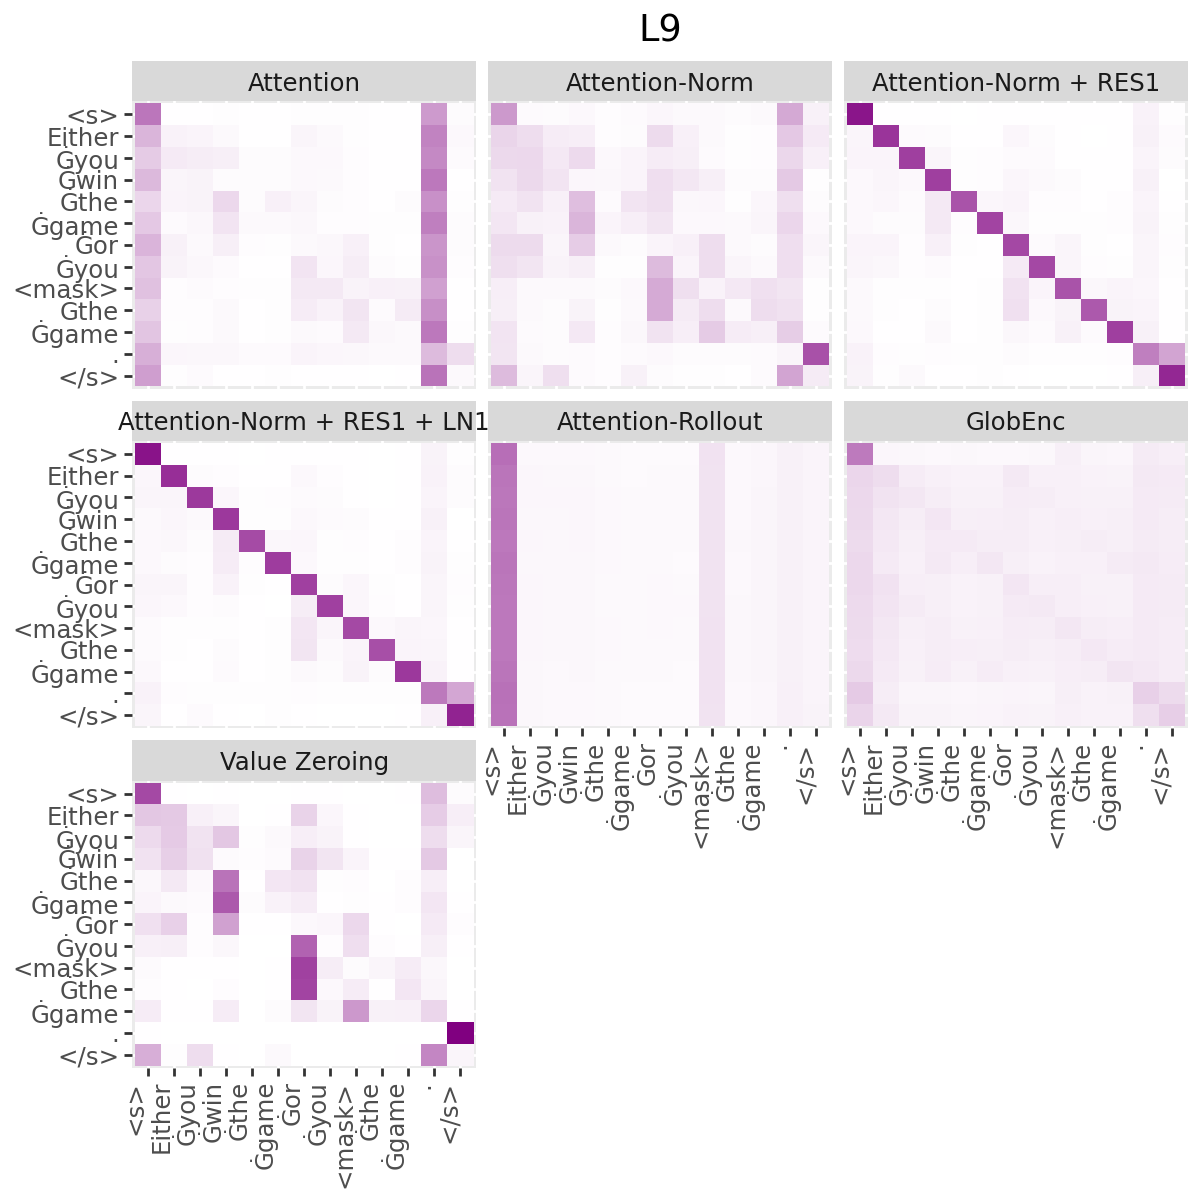

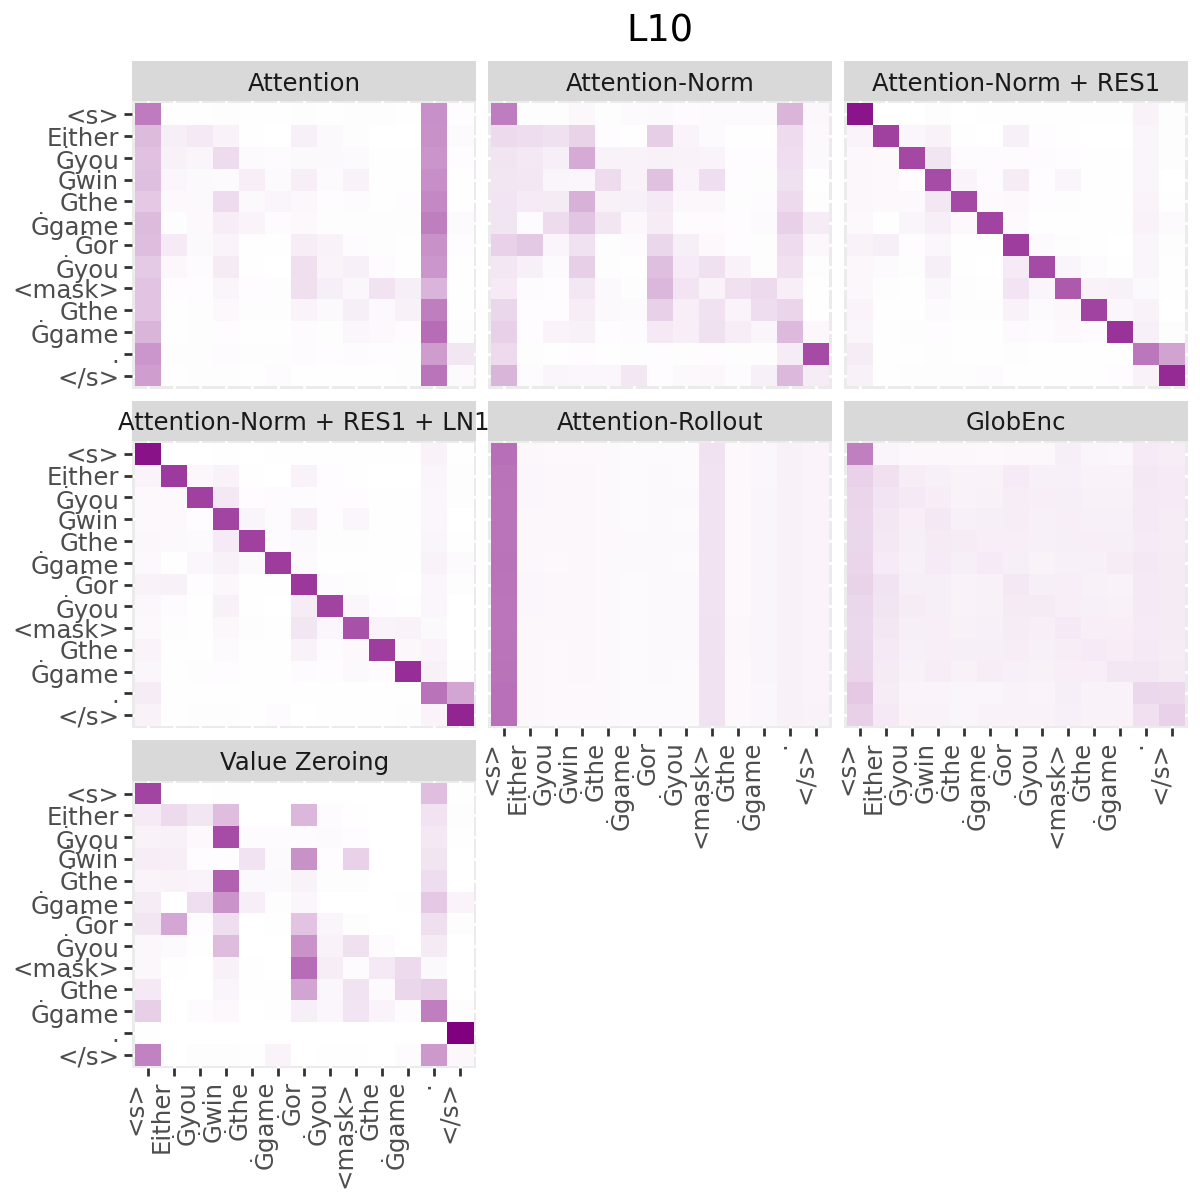

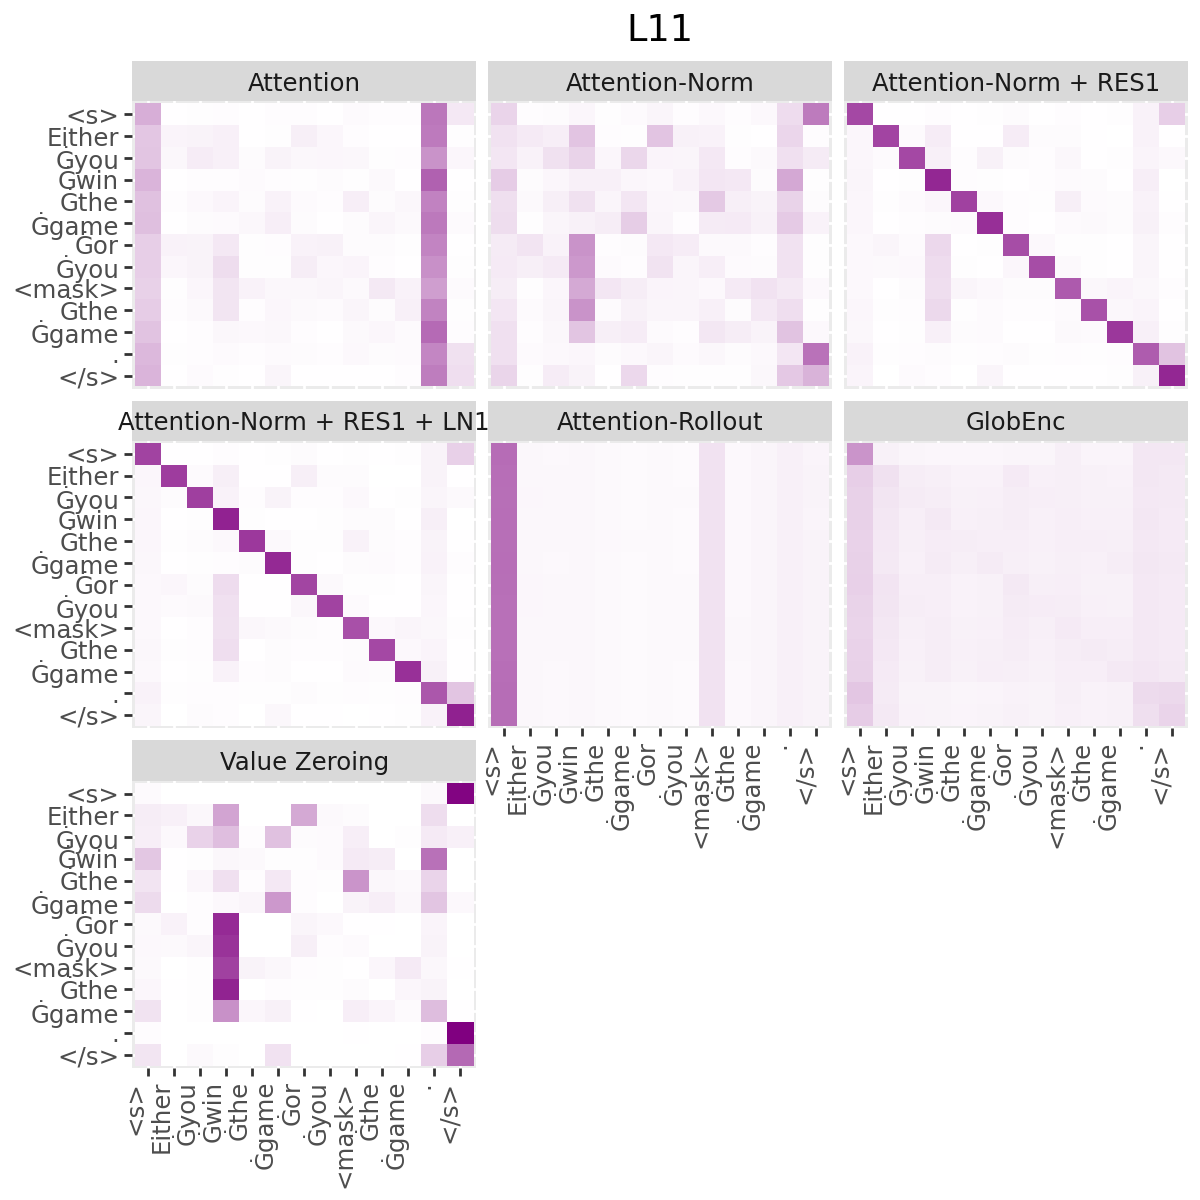

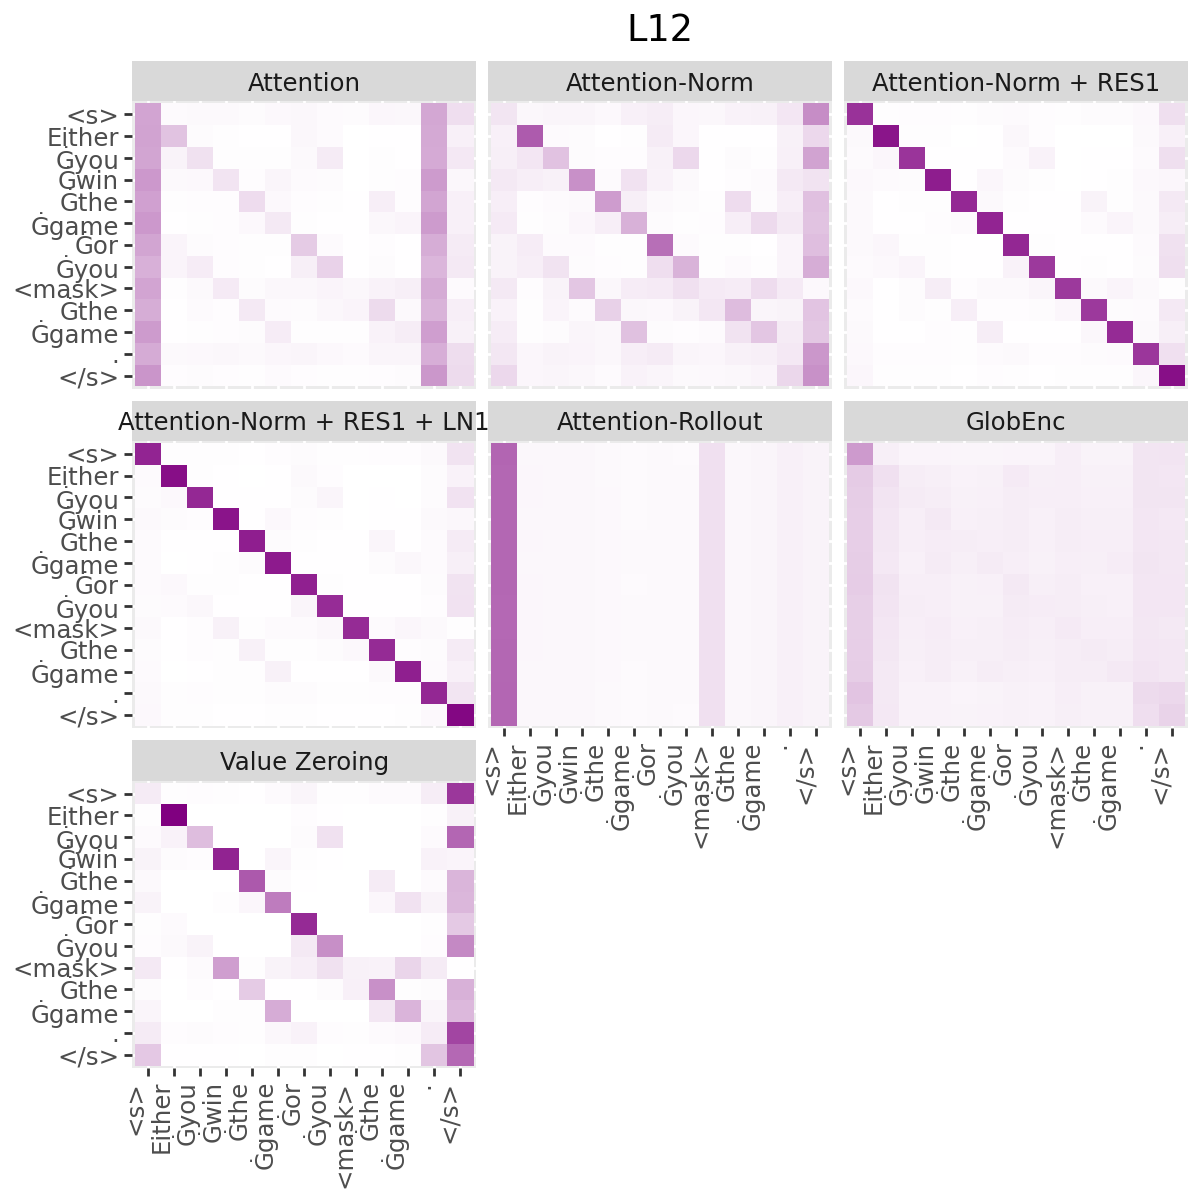

In [17]:
# @title Plot scores
tokens = [tokenizer.convert_ids_to_tokens(t) for t in inputs['input_ids'][0].detach().cpu().numpy().tolist()]
token_orders = list(range(len(tokens)))
order_to_token_mapper = {i: tokens[i] for i in token_orders}

NAMES = list(scores.keys())
num_layers, seq_len, _= scores[NAMES[0]].shape
for l in range(num_layers):
    df_list = []
    for name in NAMES:
        df = pd.DataFrame(scores[name][l], index=token_orders, columns=token_orders).reset_index()
        df = df.melt(id_vars='index')
        df.columns = ['x', 'y', 'value']
        df['method'] = name
        df_list.append(df)
    merged_df = pd.concat(df_list)
    merged_df['x'] = pd.Categorical(merged_df['x'], categories=token_orders)
    merged_df['y'] = pd.Categorical(merged_df['y'], categories=token_orders)

    p = (ggplot(merged_df, aes('y', 'x', fill='value'))
        + geom_tile()
        + scale_fill_gradient(low='white', high='purple', guide=None)
        + facet_wrap('~method')
        + theme(axis_text_x=element_text(rotation=90, hjust=1), axis_title_x=element_blank(), axis_title_y=element_blank(), figure_size=(6, 6))
        + scale_x_discrete(labels=[order_to_token_mapper[i] for i in token_orders])
        + scale_y_discrete(labels=[order_to_token_mapper[i] for i in token_orders][::-1], limits=reversed)
        + labs(title=f"L{l+1}")
        )
    display(p)